# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello, World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
January, 2022

## Dimuon mass spectrum calculation with Spark UDF using Scala UDF

In [ ]:
# Download the data (2 GB) if not yet available locally

! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

In [1]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.3.0-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("dimuon mass")
         .master("local[4]")
         .config("spark.driver.memory", "2g")
         .config("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/05/20 16:55:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/20 16:55:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read data with the muon candidate events
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "./"
df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")

df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [3]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")


In [4]:
# Pandas UDF
# Computes the dimuon invarian mass
# This uses the full coordinate conversion and formula
# It is not an optimized way to do the computation

from pyspark.sql.functions import pandas_udf
from numpy import cos, sin, sinh, sqrt
import pandas as pd

@pandas_udf("float")
def DimuonMass(pt: pd.Series, eta: pd.Series, phi: pd.Series, mass: pd.Series) -> pd.Series:
    pt = pd.DataFrame(pt.tolist(), columns=['0','1'])
    phi = pd.DataFrame(phi.tolist(), columns=['0','1'])
    eta = pd.DataFrame(eta.tolist(), columns=['0','1'])
    mass = pd.DataFrame(mass.tolist(), columns=['0','1'])
    
    px = pt * cos(phi)
    py = pt * sin(phi)
    pz = pt * sinh(eta)
    E = sqrt(mass * mass + (px * px + py * py + pz * pz) )

    px_tot = px["0"] + px["1"]
    py_tot = py["0"] + py["1"]
    pz_tot = pz["0"] + pz["1"]
    E_tot = E["0"] + E["1"]
    
    invariant_mass = sqrt(E_tot * E_tot - (px_tot * px_tot + py_tot * py_tot + pz_tot * pz_tot) )
    return invariant_mass

spark.udf.register("DimuonMass", DimuonMass)


<function __main__.DimuonMass(pt: pandas.core.series.Series, eta: pandas.core.series.Series, phi: pandas.core.series.Series, mass: pandas.core.series.Series) -> pandas.core.series.Series>

In [5]:
# Pandas UDF
# Computes the dimuon invarian mass
# This uses a formula in the limit E >> muons rest mas
# It runs faster than the full formula

from pyspark.sql.functions import pandas_udf
from numpy import cosh, cos, sqrt
import pandas as pd

#@pandas_udf("float")
#def DimuonMass(pt: pd.Series, eta: pd.Series, phi: pd.Series, mass: pd.Series) -> pd.Series:
#    pt = pd.DataFrame(pt.tolist(), columns=['0','1'])
#    eta = pd.DataFrame(eta.tolist(), columns=['0','1'])
#    phi = pd.DataFrame(phi.tolist(), columns=['0','1'])
#
#    val = sqrt(2 * pt["0"] * pt["1"] * ( cosh(eta["0"] - eta["1"]) - cos(phi["0"] - phi["1"]) ))
#    return val
#
# spark.udf.register("DimuonMass", DimuonMass)


In [6]:
df_with_dimuonmass = df_muons.selectExpr("DimuonMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass) as Dimuon_mass")


In [7]:
# This defines the DataFrame transformation to compute the Dimuon mass spectrum
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 0.25
max_val = 300
num_bins = 30000

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_with_dimuonmass, "Dimuon_mass", min_val, max_val, num_bins) 


In [8]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


/home/luca/anaconda202205/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 185 ms, sys: 13 ms, total: 198 ms
Wall time: 1min 23s


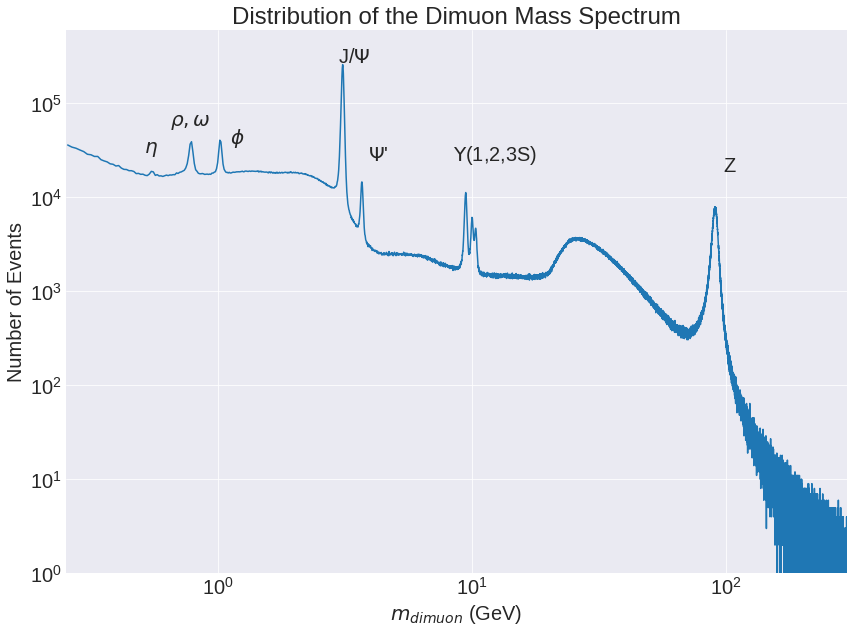

In [9]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [10]:
spark.stop()